In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import  DataLoader
import torch.nn.functional as F
from torch.nn import Transformer
from torchvision import datasets, transforms
from PIL import Image

In [3]:
import os

In [4]:
train_data = 'Potato//Train'
test_data = 'Potato/Test/'
val_data = 'Potato/Valid/'

In [5]:
classes = {'Potato___Early_blight':0,'Potato___Late_blight':1,'Potato___healthy':2}

In [6]:
train_imgs = []
c = -1
for folder, subfolder,filnames in os.walk(train_data):
    c+=1
    try:
        label1 = subfolder[0]
        label2 = subfolder[1]
        label3 = subfolder[2]
    except Exception as e:
        pass

    if c == 1:
        label = label1
    elif c == 2:
        label = label2
    else:
        label = label3
    label = classes[label]
    for images in filnames:
        train_imgs.append(((folder+'\\'+images),label))
        


In [7]:
test_imgs = []
c = -1
for folder, subfolder,filnames in os.walk(test_data):
    c+=1
    try:
        label1 = subfolder[0]
        label2 = subfolder[1]
        label3 = subfolder[2]
    except Exception as e:
        pass

    if c == 1:
        label = label1
    elif c == 2:
        label = label2
    else:
        label = label3
    label = classes[label]
    for images in filnames:
        test_imgs.append(((folder+'\\'+images),label))
        


In [8]:
val_imgs = []
c = -1
for folder, subfolder,filnames in os.walk(val_data):
    c+=1
    try:
        label1 = subfolder[0]
        label2 = subfolder[1]
        label3 = subfolder[2]
    except Exception as e:
        pass

    if c == 1:
        label = label1
    elif c == 2:
        label = label2
    else:
        label = label3
    label = classes[label]
    for images in filnames:
        val_imgs.append(((folder+'\\'+images),label))
        


In [9]:
len(train_imgs),len(test_imgs),len(val_imgs)

(900, 300, 300)

In [10]:
train_transpose = transforms.Compose([transforms.RandomRotation(20),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                    [0.229, 0.224, 0.225])])

test_transpose = transforms.Compose([transforms.Resize(224),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                    [0.229, 0.224, 0.225])])

val_transpose = transforms.Compose([transforms.Resize(224),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406],
                                   [0.229, 0.224, 0.225])])

In [11]:
class COnvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, 1)
        self.conv2 = nn.Conv2d(8, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 40)
        self.fc3 = nn.Linear(40,3)

        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
#         X = self.fc4(X)
        return F.log_softmax(X, dim=1)

In [12]:
train_vec = []
test_vec = []
val_vec = []
for im in train_imgs:
    tar = im[1]
    im = im[0]
    im = Image.open(im)
    im = im.convert('RGB')
    im = train_transpose(im)
    train_vec.append((im,tar))

for im in test_imgs:
    tar = im[1]
    im = im[0]
    im = Image.open(im)
    im = im.convert('RGB')
    im = test_transpose(im)
    test_vec.append((im,tar))

for im in val_imgs:
    tar = im[1]
    im = im[0]
    im = Image.open(im)
    im = im.convert('RGB')
    im = val_transpose(im)
    val_vec.append((im,tar))

In [13]:
torch.manual_seed(204)
train_data = DataLoader(train_vec, batch_size = 30, shuffle = True)
test_data = DataLoader(test_vec, batch_size = 10, shuffle = False)
val_data = DataLoader(val_vec, batch_size = 10, shuffle = False)

In [14]:
torch.manual_seed(200)
CNN_Model = COnvolutionalNeuralNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNN_Model.parameters(), lr=0.001)

In [15]:
epochs = 7
train_losses = []
test_losses = []
val_losses = []
train_correct = []
test_correct = []
val_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    val_corr = 0
    for b ,(X_train, y_train) in enumerate(train_data):
        b+= 1
        y_pred = CNN_Model(X_train)
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred, 1)[1]
        batch_corr = (predicted == y_train).sum()
        
        trn_corr+= batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_samples = b * train_data.batch_size
        if b%10== 0:
            print(f'epoch: {i:2}  batch: {b:4} [{total_samples:6}/30]  loss: {loss.item():10.8f}  '
          f'accuracy: {trn_corr.item()*100/total_samples:7.3f}%')
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    with torch.no_grad():
        for b,(X_test, y_test) in enumerate(test_data):
            y_test_pred = CNN_Model(X_test)
            predicted = torch.max(y_test_pred, 1)[1]
            tst_corr += (predicted == y_test).sum()
             
        loss = criterion(y_test_pred, y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr)
        
    with torch.no_grad():
        for b,(X_val, y_val) in enumerate(val_data):
            y_val_perd = CNN_Model(X_val)
            predicted = torch.max(y_val_perd, 1)[1]
            val_corr += (predicted == y_val).sum()
            
        loss = criterion(y_val_perd, y_val)
        val_losses.append(loss)
        val_correct.append(val_corr)

epoch:  0  batch:   10 [   300/30]  loss: 0.96740818  accuracy:  43.667%
epoch:  0  batch:   20 [   600/30]  loss: 0.58841479  accuracy:  57.167%
epoch:  0  batch:   30 [   900/30]  loss: 0.37515676  accuracy:  63.889%
epoch:  1  batch:   10 [   300/30]  loss: 0.40797535  accuracy:  83.667%
epoch:  1  batch:   20 [   600/30]  loss: 0.24734272  accuracy:  85.000%
epoch:  1  batch:   30 [   900/30]  loss: 0.43056494  accuracy:  85.667%
epoch:  2  batch:   10 [   300/30]  loss: 0.22719191  accuracy:  95.000%
epoch:  2  batch:   20 [   600/30]  loss: 0.17589429  accuracy:  93.833%
epoch:  2  batch:   30 [   900/30]  loss: 0.09175353  accuracy:  94.444%
epoch:  3  batch:   10 [   300/30]  loss: 0.10337862  accuracy:  97.667%
epoch:  3  batch:   20 [   600/30]  loss: 0.09226990  accuracy:  97.500%
epoch:  3  batch:   30 [   900/30]  loss: 0.10884165  accuracy:  97.778%
epoch:  4  batch:   10 [   300/30]  loss: 0.06424496  accuracy:  99.000%
epoch:  4  batch:   20 [   600/30]  loss: 0.0477593

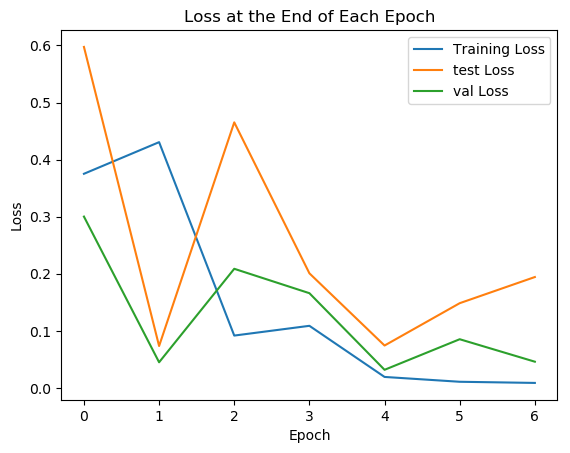

In [16]:
# Convert train_losses and test_losses to lists of floats
train_losses_float = [loss.detach().item() for loss in train_losses]
test_losses_float = [loss.detach().item() for loss in test_losses]
val_losses_float = [loss.detach().item() for loss in val_losses]
# Plot the values
import matplotlib.pyplot as plt

plt.plot(train_losses_float, label='Training Loss')
plt.plot(test_losses_float, label='test Loss')
plt.plot(val_losses_float, label = 'val Loss')
plt.title('Loss at the End of Each Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
print(f'Test accuracy: {test_correct[-1].item()*100/300:.3f}%')

Test accuracy: 94.667%


In [18]:
print(f'Val accuracy: {val_correct[-1].item()*100/300:.3f}%')

Val accuracy: 94.333%


In [19]:
print(f'Test accuracy: {train_correct[-1].item()*100/900:.3f}%')

Test accuracy: 100.000%


In [21]:
torch.save(CNN_Model.state_dict(), 'model_1.pt')